# Import necessary libraries

In [135]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

# Input Stock Symbol by client
	save it in symbol_s
    only string
    mandatory input there is no default value
    check the input by bellow command: if it returns 'EQUITY' it will be fine  

In [116]:
while True:
    symbol_s = input()
    stock = yf.Ticker(symbol_s) # General command: stock = yf.Ticker(symbol_s)
    if 'quoteType' in stock.info and stock.info['quoteType'] == 'EQUITY' :
        break
    print('invalid Code')

atvi


# Input Refrence Symbol by client
	save it in symbol_r
    only string
    default value is '^GSPC'
    check the input by bellow command: if it returns 'INDEX' it will be fine  

In [118]:
while True:
    symbol_r = input()
    reference = yf.Ticker(symbol_r) # General command: stock = yf.Ticker(symbol_s)
    if 'quoteType' in reference.info and reference.info['quoteType'] == 'INDEX' :
        break
    print('invalid Code')


^GSPC


# Checking date relevance
	Date for stock and index can be reached through below command
    Date is index column of dataframe of hist_s and hist_r
    Time period must be the same,means the shortest period will be set as the final period(start and end) for both of them

In [120]:
hist_s = stock.history(period = 'max')
hist_r = reference.history(period = 'max')
hist_s

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-10-25,1.108217,1.108217,0.831163,0.831163,18000,0.0,0.0
1993-10-26,1.089747,1.089747,0.757282,0.766516,189600,0.0,0.0
1993-10-27,0.766516,0.766516,0.766516,0.766516,0,0.0,0.0
1993-10-28,0.627989,0.738811,0.517168,0.729576,30000,0.0,0.0
1993-10-29,0.775752,0.775752,0.738811,0.738811,172800,0.0,0.0
...,...,...,...,...,...,...,...
2022-04-25,78.209999,78.470001,77.410004,78.050003,8668500,0.0,0.0
2022-04-26,77.820000,78.059998,77.019997,77.059998,10783600,0.0,0.0
2022-04-27,76.820000,77.279999,76.059998,76.099998,7318800,0.0,0.0


In [122]:
df = pd.merge(hist_s, hist_r, left_on = hist_s.index, right_on = hist_r.index)
df

,key_0,Open_x,High_x,Low_x,Close_x,Volume_x,Dividends_x,Stock Splits_x,Open_y,High_y,Low_y,Close_y,Volume_y,Dividends_y,Stock Splits_y
0,1993-10-25,1.108217,1.108217,0.831163,0.831163,18000,0.0,0.0,463.269989,464.489990,462.049988,464.200012,260310000,0,0
1,1993-10-26,1.089747,1.089747,0.757282,0.766516,189600,0.0,0.0,464.200012,464.320007,462.649994,464.299988,284530000,0,0
2,1993-10-27,0.766516,0.766516,0.766516,0.766516,0,0.0,0.0,464.299988,464.609985,463.359985,464.609985,279830000,0,0
3,1993-10-28,0.627989,0.738811,0.517168,0.729576,30000,0.0,0.0,464.519989,468.760010,464.519989,467.730011,301220000,0,0
4,1993-10-29,0.775752,0.775752,0.738811,0.738811,172800,0.0,0.0,467.720001,468.200012,467.369995,467.829987,270570000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,2022-04-25,78.209999,78.470001,77.410004,78.050003,8668500,0.0,0.0,4255.339844,4299.020020,4200.819824,4296.120117,4061070000,0,0
7177,2022-04-26,77.820000,78.059998,77.019997,77.059998,10783600,0.0,0.0,4278.140137,4278.140137,4175.040039,4175.200195,3760420000,0,0
7178,2022-04-27,76.820000,77.279999,76.059998,76.099998,7318800,0.0,0.0,4186.520020,4240.709961,4162.899902,4183.959961,3876340000,0,0
7179,2022-04-28,76.449997,77.360001,76.180000,76.699997,8164800,0.0,0.0,4222.580078,4308.450195,4188.629883,4287.500000,3969440000,0,0


# Input  Anticipation and Adjustment, and estimation window
    
    save it in ant, adj and window
    checking the numbers with these condition( 5 <= ant and adj <= 15 )
    if it doesn't meet the condition set the dafault as 10
    
    checking the number with this condition( 30 <= window <= 90 )
    if it doesn't meet the condition set the dafault as 30
    

In [123]:
ant = int(input('Enter Anticipation period in days \n'))
adj = int(input('Enter Adjustment period in days \n'))
window = int(input('Enter Estimation window in days \n'))

if  ant > 15 and ant < 5:
    ant = 10
if adj > 15 and adj < 5:
    adj = 10
if window > 90 and window < 30:
    window = 45

Enter Anticipation period in days 
10
Enter Adjustment period in days 
10
Enter Estimation window in days 
57


# Input Event Date by client
	save it in date_e
    mandatory, there is no default
    if it meet condition check necessary date to being in period time ( (date_e - (window + ant + 1) and (date_e + adj + 15)) is in period time of dataframes 
    becareful Date column is working days(go forward and behind as rows of data frame to check)

In [124]:
while True:
    date_e = pd.to_datetime(input("Enter the event date with this format : YYYY/MM/DD \n"))
    if date_e not in df.key_0.values:
        print("Invalid Date")
        continue
    index = df[df.key_0 == date_e].index[0]
    max_index = df.index.max()
    if (window + ant + 1) < index < max_index - (adj + 15):
        break
    print('the date in not relevant')

Enter the event date with this format : YYYY/MM/DD 
2018/11/05


# Calculate return for stock and index
    return: return = adj_close(0)% adjclose(-1)
    save it in return_s and return_r
    date from first date of estimation date to 15 days after the last day of adjustment date
    build new dataframe as returns

In [125]:
index = df[df.key_0 == date_e].index[0]
returns = df[(df.index >= index - (window + ant + 1)) & (df.index <= index + adj + 15 )][['key_0', 'Close_x', 'Close_y']]
returns.columns = ['Date', 'Close_s', 'Close_r']
# print(returns)
returns['return_s'] = ((returns['Close_s'] / returns['Close_s'].shift(1)) - 1)
returns['return_r'] = ((returns['Close_r'] / returns['Close_r'].shift(1)) - 1)
returns.dropna(inplace = True)
returns

,Date,Close_s,Close_r,return_s,return_r
6237,2018-08-01,71.253357,2813.360107,-0.004631,-0.001040
6238,2018-08-02,72.208855,2827.219971,0.013410,0.004926
6239,2018-08-03,69.537346,2840.350098,-0.036997,0.004644
6240,2018-08-06,68.806091,2850.399902,-0.010516,0.003538
6241,2018-08-07,68.474586,2858.449951,-0.004818,0.002824
...,...,...,...,...,...
6325,2018-12-06,46.946480,2695.949951,0.035039,-0.001522
6326,2018-12-07,46.049477,2633.080078,-0.019107,-0.023320
6327,2018-12-10,46.683231,2637.719971,0.013762,0.001762
6328,2018-12-11,46.995232,2636.780029,0.006683,-0.000356


# Calculate Abnormal returns
    MAR = return_s - average(return_s) average for all days in estimation window
    MKAR = return_s - return_r
    RAR = return_s - (alpha + beta * return_r) alpha and beta are regression coefficients of stock against market through estimation window
    3 new column to dataframe of return

In [136]:
returns['MAR'] = returns['return_s'] - returns.iloc[0 : window, 4].mean()
returns['MKAR'] = returns['return_s'] - returns['return_r']

model = LinearRegression().fit(returns[['return_r']], returns['return_s'])
alpha = model.intercept_
beta = model.coef_[0]
returns['RAR'] = returns['return_s'] - (alpha + beta * returns['return_r'])

returns

,Date,Close_s,Close_r,return_s,return_r,MAR,MKAR,RAR
6237,2018-08-01,71.253357,2813.360107,-0.004631,-0.001040,-0.004354,-0.003590,-0.000077
6238,2018-08-02,72.208855,2827.219971,0.013410,0.004926,0.013686,0.008483,0.010976
6239,2018-08-03,69.537346,2840.350098,-0.036997,0.004644,-0.036721,-0.041641,-0.039100
6240,2018-08-06,68.806091,2850.399902,-0.010516,0.003538,-0.010240,-0.014054,-0.011324
6241,2018-08-07,68.474586,2858.449951,-0.004818,0.002824,-0.004542,-0.007642,-0.004790
...,...,...,...,...,...,...,...,...
6325,2018-12-06,46.946480,2695.949951,0.035039,-0.001522,0.035315,0.036561,0.040156
6326,2018-12-07,46.049477,2633.080078,-0.019107,-0.023320,-0.018831,0.004213,0.011536
6327,2018-12-10,46.683231,2637.719971,0.013762,0.001762,0.014039,0.012000,0.015034
6328,2018-12-11,46.995232,2636.780029,0.006683,-0.000356,0.006960,0.007040,0.010436


<AxesSubplot:xlabel='Date'>

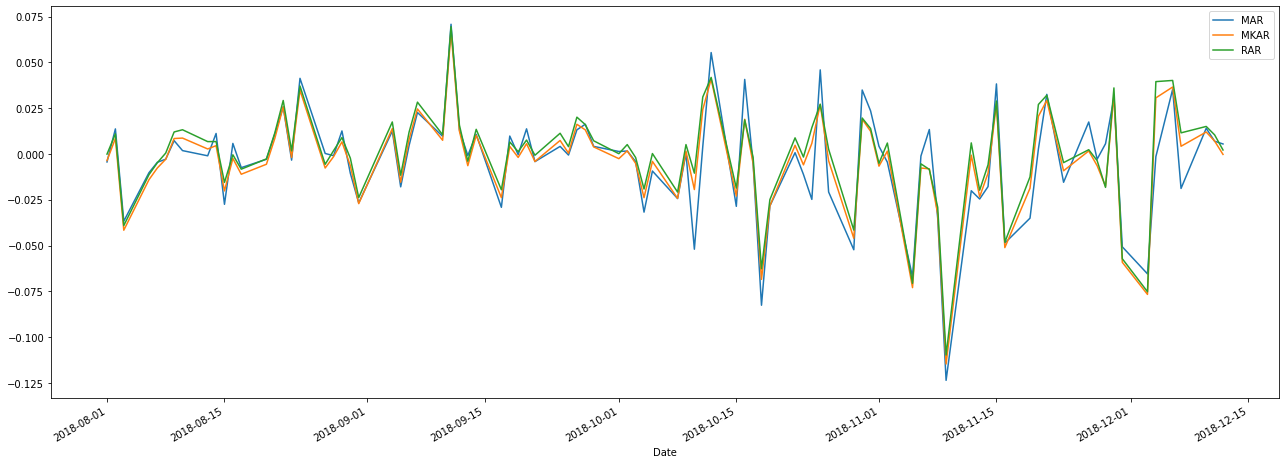

In [137]:
returns.plot(x="Date", y=["MAR", "MKAR", "RAR"], kind="line", figsize=(22, 8))

# Calculate Standard Deviation for Abnormal returns
    stdev_all for MAR, MKAR, RAR as new columns of new dataframe name results(from first date to 15 after adj)
    stdev_ant for MAR, ....
    stdev_adj for MAR, ....
    stdev_per for ...
    stdev's as rows of dataframe

# Formula
    stdev_all = np.std(list of Mar values, ...)
    stdev_ant = stdev_all * (ant ** 1/2)
    stdev_adj = stdev_all * (adj ** 1/2)
    stdev_per = stdev_all * ((ant + adj + 1) ** 1/2)

In [150]:
results_0 = {'Statistics' : ['stdev_all'], 'MAR' : [np.std(returns.iloc[0: window, 5])], 'MKAR': [np.std(returns.iloc[0: window, 6])], 'RAR': [np.std(returns.iloc[0: window, 7])]}
results =pd.DataFrame.from_dict(results_0).set_index('Statistics')
results.loc['stdev_ant'] = results.apply(lambda x: x["stdev_all"] * (ant ** 0.5))
results.loc['stdev_adj'] = results.apply(lambda x: x["stdev_all"] * (adj ** 0.5))
results.loc['stdev_per'] = results.apply(lambda x: x["stdev_all"] * ((ant + adj + 1) ** 0.5))
results

,MAR,MKAR,RAR
Statistics,,,
stdev_all,0.023643,0.020076,0.019690
stdev_ant,0.074766,0.063487,0.062265
stdev_adj,0.074766,0.063487,0.062265
stdev_per,0.108347,0.092001,0.090231
